<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Generative adversarial networks</b></h3>



## Подготовка данных!

В данных, предоставленных по ссылке пристутсвуют лишние файлы - не формата картинки. Их проще всего удалить вручную, чем реализовывать скрипт по очистке или поиска по формату. 

После очистки картинок, полученные изображения снова запаковываются в архив. Дальше его нужно подгрузить в Colab или kaggle

### Дополнительная информация
Обучение gan'а на kaggle занимает примерно 2-2.5 часа. На colab это займет примерно часов 5.   
Обучение KNeighborsClassifier + TSNE добавляет примерно 40-50 минут


In [ ]:
# Нужно при запуске на kaggle
!pip install torchsummary

В этом домашнем задании вы обучите GAN генерировать лица людей и посмотрите на то, как можно оценивать качество генерации

In [ ]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
from pathlib import Path
from torchsummary import summary



import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

## Часть 1. Подготовка данных (1 балл)

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://drive.google.com/file/d/1KWPc4Pa7u2TWekUvNu9rTSO0U2eOlZA9/view?usp=sharing)

Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения (размер 1024 слишком большой, поэтому мы рекомендуем взять размер 128 либо немного больше)

In [ ]:
# Нужно при запуске на Colab
# from google.colab import drive
# drive.mount('/content/drive/')

In [ ]:
# Нужно при запуске на Colab
# !unzip -q /content/drive/MyDrive/DeepLearningSchool/20.GAN/faces_dataset_small.zip -d data
# !ls

In [ ]:
# Нужно при запуске на Colab
# !pwd
# !ls /content/data/faces_dataset_small

In [ ]:
# Нужно при запуске на kaggle
!mkdir ./data
!cp -R ../input/faces-dataset-small/faces_dataset_small ./data
!ls ./data/faces_dataset_small | wc -l

3143


In [ ]:
def get_dataloader(image_size, batch_size):
    """
    Builds dataloader for training data.
    Use tt.Compose and tt.Resize for transformations
    :param image_size: height and wdith of the image
    :param batch_size: batch_size of the dataloader
    :returns: DataLoader object 
    """
    # TODO: resize images, convert them to tensors and build dataloader
#     data_dir = Path('/content/data')
    data_dir = Path('./data')
    stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
    train_ds = ImageFolder(data_dir, 
                         transform=tt.Compose([
                                               tt.Resize(image_size),
                                               tt.ToTensor(),
                                               tt.Normalize(*stats)
                                               ]))

    return torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)     


In [ ]:
image_size = 128
batch_size = 64

data_loader = get_dataloader(image_size=image_size, batch_size=batch_size)
#TODO: build dataloader and transfer it to device

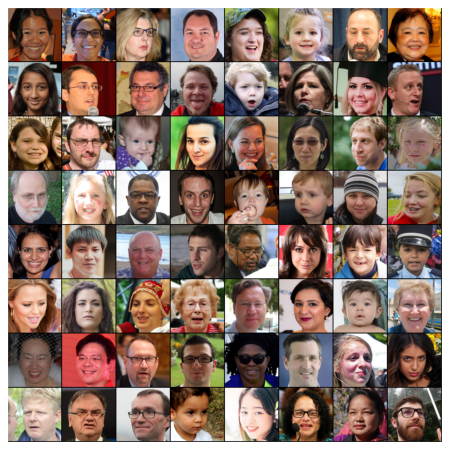

In [ ]:
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

show_batch(data_loader)

## Часть 2. Построение и обучение модели (2 балла)

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

In [ ]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(data_loader, device)

In [ ]:
discriminator = nn.Sequential(
    # in: 3*128*128
    nn.Conv2d(3, 128,  kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128*64*64

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 16 x 16

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(1024),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(1024, 2048, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(2048),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(2048, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid()
)

discriminator = to_device(discriminator, device)
summary(discriminator, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 64, 64]           6,144
       BatchNorm2d-2          [-1, 128, 64, 64]             256
         LeakyReLU-3          [-1, 128, 64, 64]               0
            Conv2d-4          [-1, 256, 32, 32]         524,288
       BatchNorm2d-5          [-1, 256, 32, 32]             512
         LeakyReLU-6          [-1, 256, 32, 32]               0
            Conv2d-7          [-1, 512, 16, 16]       2,097,152
       BatchNorm2d-8          [-1, 512, 16, 16]           1,024
         LeakyReLU-9          [-1, 512, 16, 16]               0
           Conv2d-10           [-1, 1024, 8, 8]       8,388,608
      BatchNorm2d-11           [-1, 1024, 8, 8]           2,048
        LeakyReLU-12           [-1, 1024, 8, 8]               0
           Conv2d-13           [-1, 2048, 4, 4]      33,554,432
      BatchNorm2d-14           [-1, 204

In [ ]:
latent_size = 1024

In [ ]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 1024, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(1024),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 1024 x 4 x 4

    nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 8 x 8

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 16 x 16

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 32 x 32

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 128 x 128
)

generator = to_device(generator, device)
summary(generator, (latent_size, 1, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1           [-1, 1024, 4, 4]      16,777,216
       BatchNorm2d-2           [-1, 1024, 4, 4]           2,048
         LeakyReLU-3           [-1, 1024, 4, 4]               0
   ConvTranspose2d-4            [-1, 512, 8, 8]       8,388,608
       BatchNorm2d-5            [-1, 512, 8, 8]           1,024
         LeakyReLU-6            [-1, 512, 8, 8]               0
   ConvTranspose2d-7          [-1, 256, 16, 16]       2,097,152
       BatchNorm2d-8          [-1, 256, 16, 16]             512
         LeakyReLU-9          [-1, 256, 16, 16]               0
  ConvTranspose2d-10          [-1, 128, 32, 32]         524,288
      BatchNorm2d-11          [-1, 128, 32, 32]             256
        LeakyReLU-12          [-1, 128, 32, 32]               0
  ConvTranspose2d-13           [-1, 64, 64, 64]         131,072
      BatchNorm2d-14           [-1, 64,

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [ ]:
lr = 0.0001

model_fit = {
    "discriminator": discriminator,
    "generator": generator
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}

In [ ]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)
fixed_latent = torch.randn(128, latent_size, 1, 1, device=device)

def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [ ]:
def fit(model, criterion, epochs, lr, start_idx=1):
    model["discriminator"].train()
    model["generator"].train()
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    optimizer = {
        "discriminator": torch.optim.Adam(model["discriminator"].parameters(), 
                                          lr=lr, betas=(0.5, 0.999)),
        "generator": torch.optim.Adam(model["generator"].parameters(),
                                      lr=lr, betas=(0.5, 0.999))
    }
    
    for epoch in range(epochs):
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []
        for real_images, _ in train_dl:
            # Train discriminator
            # Clear discriminator gradients
            optimizer["discriminator"].zero_grad()

            # Pass real images through discriminator
            real_preds = model["discriminator"](real_images)
            real_targets = torch.ones(real_images.size(0), 1, device=device)
            real_loss = criterion["discriminator"](real_preds, real_targets)
            cur_real_score = torch.mean(real_preds).item()
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)

            # Pass fake images through discriminator
            fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
            fake_preds = model["discriminator"](fake_images)
            fake_loss = criterion["discriminator"](fake_preds, fake_targets)
            cur_fake_score = torch.mean(fake_preds).item()

            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)

            # Update discriminator weights
            loss_d = real_loss + fake_loss
            loss_d.backward()
            optimizer["discriminator"].step()
            loss_d_per_epoch.append(loss_d.item())


            # Train generator
            # Clear generator gradients
            optimizer["generator"].zero_grad()
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)
            
            # Try to fool the discriminator
            preds = model["discriminator"](fake_images)
            targets = torch.ones(batch_size, 1, device=device)
            loss_g = criterion["generator"](preds, targets)
            
            # Update generator weights
            loss_g.backward()
            optimizer["generator"].step()
            loss_g_per_epoch.append(loss_g.item())
            
        # Record losses & scores
        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, 
            losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1]))
    
        # Save generated images
        if epoch == epochs - 1:
            save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [ ]:
epochs = 40
history = fit(model_fit, criterion, epochs, lr)

Epoch [1/40], loss_g: 20.7846, loss_d: 0.1040, real_score: 0.9771, fake_score: 0.0301
Epoch [2/40], loss_g: 31.5940, loss_d: 0.0022, real_score: 0.9984, fake_score: 0.0000
Epoch [3/40], loss_g: 23.1055, loss_d: 0.0241, real_score: 0.9942, fake_score: 0.0082
Epoch [4/40], loss_g: 15.1254, loss_d: 0.0156, real_score: 0.9964, fake_score: 0.0096
Epoch [5/40], loss_g: 10.9128, loss_d: 0.0098, real_score: 0.9966, fake_score: 0.0051
Epoch [6/40], loss_g: 12.0296, loss_d: 0.2047, real_score: 0.9723, fake_score: 0.0311
Epoch [7/40], loss_g: 10.0263, loss_d: 0.2809, real_score: 0.9676, fake_score: 0.0483
Epoch [8/40], loss_g: 10.5169, loss_d: 0.1584, real_score: 0.9666, fake_score: 0.0388
Epoch [9/40], loss_g: 10.5431, loss_d: 0.3010, real_score: 0.9578, fake_score: 0.0500
Epoch [10/40], loss_g: 7.3184, loss_d: 0.7918, real_score: 0.8543, fake_score: 0.1238
Epoch [11/40], loss_g: 4.6390, loss_d: 0.4776, real_score: 0.8680, fake_score: 0.1316
Epoch [12/40], loss_g: 4.9775, loss_d: 0.5811, real_sc

In [ ]:
losses_g, losses_d, real_scores, fake_scores = history

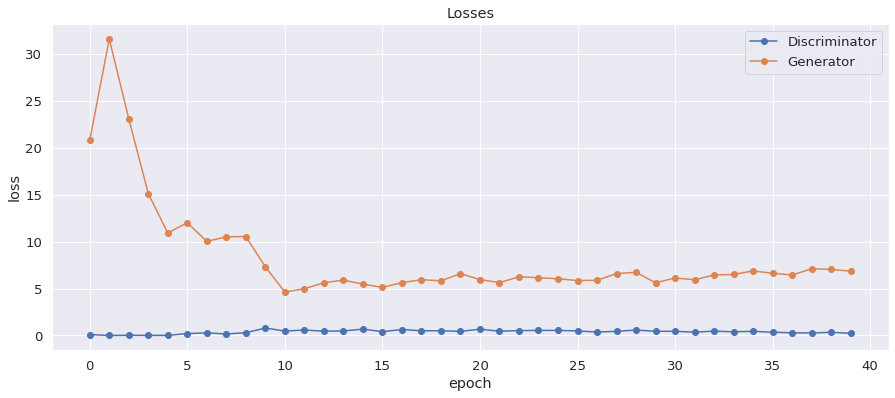

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(losses_d, '-o')
plt.plot(losses_g, '-o')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses')
plt.show()

Постройте графики лосса для генератора и дискриминатора. Что вы можете сказать про эти графики?

Потери для дискриминатора довольно хорошо стабилизировались. Потери для генератора довольно сильно колеблется. Возможно при увеличении числа эпох или уменьшении шага будет виден переход, по которому видно, что график потерь для генератора будет расти, а график дискриминатора падать. Все это возможно при условии равных возможностей дискриминатора и генератора

Особенность для модели с латентным слоем в 1024 является тот факт, что потери на генераторе слабо меняются. Возможно стоит использовать изменяющийся уровень обучения: 

from torch.optim import lr_scheduler    
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)   

## Часть 3. Генерация изображений (1 балл)

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

In [ ]:
n_images = 32

fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)
fake_images = model_fit["generator"](fixed_latent)
print(fake_images.shape)

torch.Size([32, 3, 128, 128])


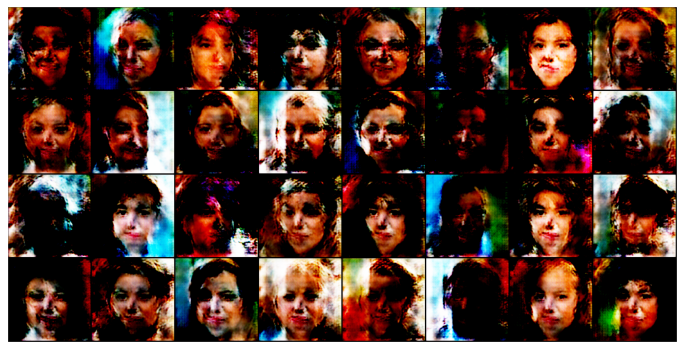

In [ ]:
def show_images(generated):
    # TODO: show generated images
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

show_images(fake_images)

Как вам качество получившихся изображений?

Лица, если присмотреться, можно увидеть. Однако к цвету изображений точно есть вопросы    

Была проверена гипотеза о том, что при увеличении латентного слоя улучшиться качество изображений. Для сравнения был взят латентный слой в 256 и 1024. Для обучения использовались 40 эпох с фиксированным уровнем обучения. По предсказанным изображениям (изображения для слоя в 256 не показаны в данном jupiter notebook) данный параметр влияет слабо.

Интересно узнать, что надо сделать чтобы повысить качество

## Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)

### 4.1. Подсчет accuracy (4 балла)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

In [ ]:
! nvidia-smi

Wed Jan  5 13:36:38 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.04   Driver Version: 450.119.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    41W / 250W |   5371MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Усреднение изображения по всем 3 цветам можно было сделать. Заменив
# real_image.append(i[0][0][0].numpy().ravel())
# на 
# real_image.append(((i[0][0][0]+i[0][0][1]+i[0][0][2])/3).numpy().ravel())
# Но смысла в этом пока не видно

real_image = []
fake_image = []

image_size = 128
batch_size = 1
data_loader = get_dataloader(image_size=image_size, batch_size=batch_size)

for i in data_loader:
    real_image.append(i[0][0][0].numpy().ravel())
real_image = np.asarray(real_image)
print(real_image.shape)

for i in range(449):
    torch.cuda.empty_cache()
    fixed_latent = torch.randn(7, latent_size, 1, 1, device=device)
    new_images = model_fit["generator"](fixed_latent).cpu().detach()
    for i in new_images:
        fake_image.append(i[0].numpy().ravel())  
fake_image = np.asarray(fake_image)
print(fake_image.shape)

X_data = np.vstack((fake_image, real_image))
y_data = np.hstack((
    np.linspace(0, 0, len(fake_image)), 
    np.linspace(1, 1, len(real_image))
    ))

(3143, 16384)
(3143, 16384)


Использование KNeighborsClassifier и TSNE в среде kaggle и colab обходится долго по времени. Поэтому данные сохраняются в файл и дальнейшие расчеты идут на личном ПК.

In [ ]:
np.savetxt("./x.csv", X_data, delimiter=",")
np.savetxt("./y.csv", y_data, delimiter=",")

###  Подсчет средней точности для сгенерированных и реальных изображений при размере латентного слоя 256

In [ ]:
# Нужно при запуске на Colab
from google.colab import drive
drive.mount('/content/drive/')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import numpy as np

X_data = np.zeros((6286, 128*128))
with open('/content/drive/MyDrive/DeepLearningSchool/20.GAN/x_256.csv','rb') as f:
    lines=f.readlines()
    for i in range(len(lines)):
        X_data[i] = np.fromstring(lines[i], dtype=float, sep=',')
print(X_data.shape)

y_data = np.genfromtxt('/content/drive/MyDrive/DeepLearningSchool/20.GAN/y_256.csv', delimiter='\n')
print(y_data.shape)

(6286, 16384)
(6286,)


In [ ]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score

import time

# X_data = np.genfromtxt(r'C:\Users\user\x_256.csv', encoding='ascii', delimiter=',')
# y_data = np.genfromtxt(r'C:\Users\user\y_256.csv', encoding='ascii', delimiter='\n')

loo = LeaveOneOut()
answer = []
start_time = time.time()
fl = 0
for train_index, test_index in loo.split(X_data):
    neigh = KNeighborsClassifier(n_neighbors=1)
    neigh.fit(X_data[train_index], y_data[train_index]) 
    answer.append(accuracy_score(neigh.predict(X_data[test_index]), y_data[test_index]))
    fl += 1
    if fl%300 == 0:
        print(fl)

print("Описание результатов: ",
      "\n 1) accuracy ~ 0 - генератор победил дискриминатор", 
      "\n 2) accuracy ~ 1 - дискриминатор победил генератор", 
      "\n 3) accuracy ~ 0.5 - генератор и дискриминатор находятся в балансе")

print('Качество различия (accuracy) реальных от сгенерированных изображений ', 
      '%.2f%%' %((sum(answer)/len(answer)*100))
     )
print("Wasted time: {:.0f}".format(time.time()-start_time))

300
600
900
1200
1500
1800
2100
2400
2700
3000
3300
3600
3900
4200
4500
4800
5100
5400
5700
6000
Описание результатов:  
 1) accuracy ~ 0 - генератор победил дискриминатор 
 2) accuracy ~ 1 - дискриминатор победил генератор 
 3) accuracy ~ 0.5 - генератор и дискриминатор находятся в балансе
Качество различия (accuracy) реальных от сгенерированных изображений  98.43%
Wasted time: 4060


### 4.2. Визуализация распределений (2 балла)

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


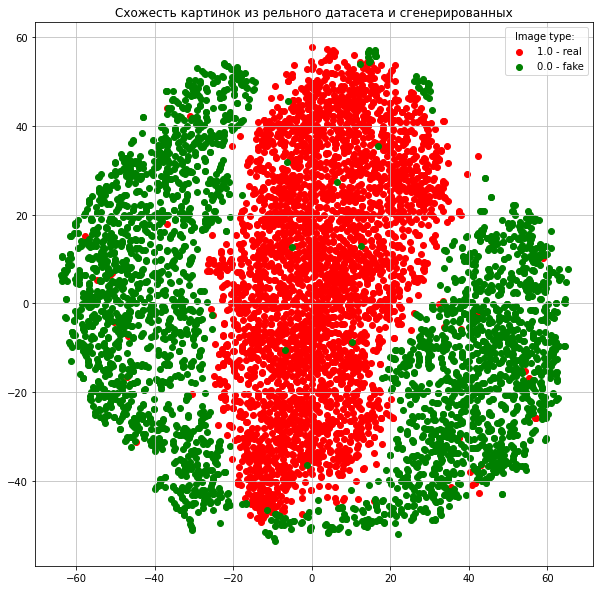

In [ ]:
# Draw TSNE
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline


result_tsne = TSNE(n_components=2).fit_transform(X_data)

plt.figure(figsize=(10, 10))
plt.grid(color='0.75')
new_x0 = np.array_split(result_tsne[:, 0], 2)
new_x1 = np.array_split(result_tsne[:, 1], 2)
new_y = np.array_split(y_data, 2)

plt.title('Схожесть картинок из рельного датасета и сгенерированных')

plt.scatter(new_x0[1], 
            new_x1[1], 
            c='r', cmap='gist_rainbow', label=f'{new_y[1][0]} - real')

plt.scatter(new_x0[0], 
            new_x1[0], 
            c='g', cmap='gist_rainbow', label=f'{new_y[0][0]} - fake')

plt.legend(title="Image type: ")

###  Подсчет средней точности для сгенерированных и реальных изображений при размере латентного слоя 1024

In [1]:
# Нужно при запуске на Colab
from google.colab import drive
drive.mount('/content/drive/')


Mounted at /content/drive/


In [2]:
import numpy as np

X_data = np.zeros((6286, 128*128))
with open('/content/drive/MyDrive/DeepLearningSchool/20.GAN/x_1024.csv','rb') as f:
    lines=f.readlines()
    for i in range(len(lines)):
        X_data[i] = np.fromstring(lines[i], dtype=float, sep=',')
print(X_data.shape)

y_data = np.genfromtxt('/content/drive/MyDrive/DeepLearningSchool/20.GAN/y_1024.csv', delimiter='\n')
print(y_data.shape)

(6286, 16384)
(6286,)


In [3]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score

import time

# X_data = np.genfromtxt(r'C:\Users\user\x_1024.csv', encoding='ascii', delimiter=',')
# y_data = np.genfromtxt(r'C:\Users\user\y_1024.csv', encoding='ascii', delimiter='\n')

loo = LeaveOneOut()
answer = []
start_time = time.time()
fl = 0
for train_index, test_index in loo.split(X_data):
    neigh = KNeighborsClassifier(n_neighbors=1)
    neigh.fit(X_data[train_index], y_data[train_index]) 
    answer.append(accuracy_score(neigh.predict(X_data[test_index]), y_data[test_index]))
    fl += 1
    if fl%300 == 0:
        print(fl)

print("Описание результатов: ",
      "\n 1) accuracy ~ 0 - генератор победил дискриминатор", 
      "\n 2) accuracy ~ 1 - дискриминатор победил генератор", 
      "\n 3) accuracy ~ 0.5 - генератор и дискриминатор находятся в балансе")

print('Качество различия (accuracy) реальных от сгенерированных изображений ', 
      '%.2f%%' %((sum(answer)/len(answer)*100))
     )
print("Wasted time: {:.0f}".format(time.time()-start_time))

300
600
900
1200
1500
1800
2100
2400
2700
3000
3300
3600
3900
4200
4500
4800
5100
5400
5700
6000
Описание результатов:  
 1) accuracy ~ 0 - генератор победил дискриминатор 
 2) accuracy ~ 1 - дискриминатор победил генератор 
 3) accuracy ~ 0.5 - генератор и дискриминатор находятся в балансе
Качество различия (accuracy) реальных от сгенерированных изображений  96.63%
Wasted time: 3545


### 4.2. Визуализация распределений (2 балла)

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


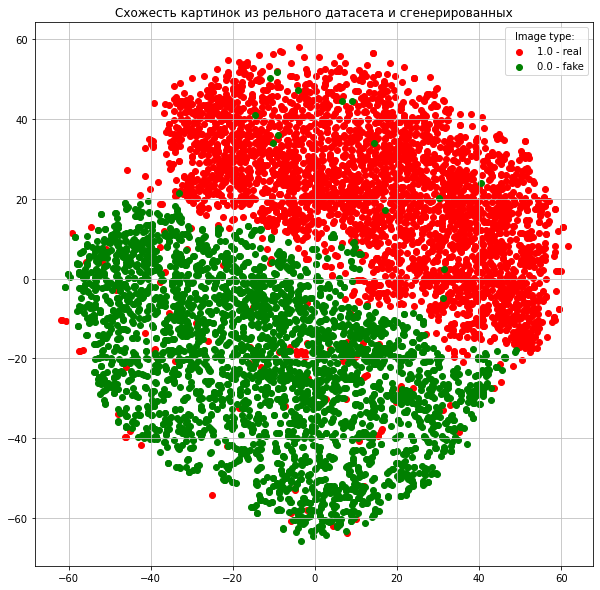

In [4]:
# Draw TSNE
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline


result_tsne = TSNE(n_components=2).fit_transform(X_data)

plt.figure(figsize=(10, 10))
plt.grid(color='0.75')
new_x0 = np.array_split(result_tsne[:, 0], 2)
new_x1 = np.array_split(result_tsne[:, 1], 2)
new_y = np.array_split(y_data, 2)

plt.title('Схожесть картинок из рельного датасета и сгенерированных')

plt.scatter(new_x0[1], 
            new_x1[1], 
            c='r', cmap='gist_rainbow', label=f'{new_y[1][0]} - real')

plt.scatter(new_x0[0], 
            new_x1[0], 
            c='g', cmap='gist_rainbow', label=f'{new_y[0][0]} - fake')

plt.legend(title="Image type: ")

# Итоги

Что вы можете сказать о получившемся результате? Какой accuracy мы хотели бы получить и почему?

Прокомментируйте получившийся результат:

1) Обучение GAN проводил на kaggle. Там доступна более мощная видеокарта и расчеты идут быстрее раза в 2-3  
2) Обучение классификатора и понижение размерности проводил на своем ноутбуке. Причина в том, что для расчета одной точки на kaggle нужно порядка 36 секунд, для расчета 100 точек на colab нужно порядка 70 секунд, для расчета 100 точек на личном ПК - 60


Вариант - добавить полносвязные слои в дискриминатор и генератор для улучшения качества модели - не проверена

### Зависимость скорости расчетов для личного ПК и colab

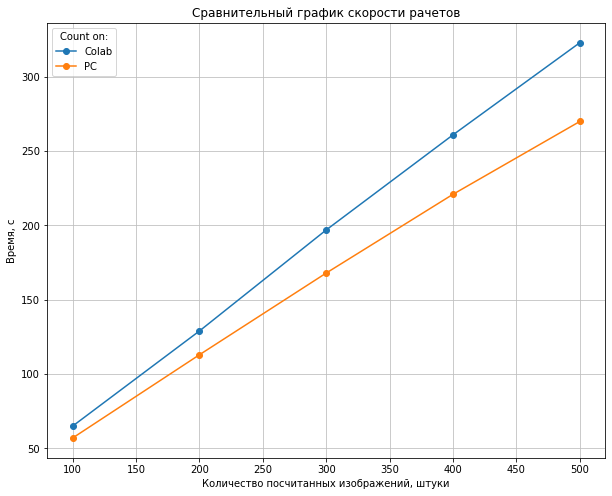

In [5]:
import matplotlib.pyplot as plt

x = [100, 200, 300, 400, 500]
y_colab = [65, 129, 197, 261, 323]
y_pc = [57, 113, 168, 221, 270]

plt.figure(figsize=(10, 8))
plt.grid(color='0.75')
plt.title('Сравнительный график скорости рачетов')
plt.xlabel('Количество посчитанных изображений, штуки')
plt.ylabel('Время, с')
plt.plot(x, y_colab, '-o', label='Colab')
plt.plot(x, y_pc, '-o', label='PC')
plt.legend(title='Count on:')